# **Predicting flight delays in US**
**Task from ML course by [ods.ai](https://ods.ai)**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!pip install catboost
!pip install holidays
import warnings
import numpy as np
import pandas as pd
import seaborn
import holidays
import json
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier
from datetime import date, timedelta

     |████████████████████████████████| 62.9MB 125kB/s 


**Read the data**

In [0]:
train_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/kaggle/ml_course/flight_delays/flight_delays_train.csv')

In [0]:
def preprocess(df):
  df = df.copy()
  
  df['DepTime_hour']    = (df['DepTime'] // 100).astype(np.int32)
  df['DepTime_minute']  = (df['DepTime'] %  100).astype(np.int32)
  df['Distance']        = (df['Distance']).astype(np.int32)
  df['Month']           = df['Month'].apply(lambda x: x.split('-')[1]).astype(np.int32)
  df['DayofMonth']      = df['DayofMonth'].apply(lambda x: x.split('-')[1]).astype(np.int32)
  df['DayOfWeek']       = df['DayOfWeek'].apply(lambda x: x.split('-')[1]).astype(np.int32)
    
  return df

In [0]:
train_df = preprocess(train_df)

In [6]:
train_df.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min,DepTime_hour,DepTime_minute
0,8,21,7,1934,AA,ATL,DFW,732,N,19,34
1,4,20,3,1548,US,PIT,MCO,834,N,15,48
2,9,2,5,1422,XE,RDU,CLE,416,N,14,22
3,11,25,6,1015,OO,DEN,MEM,872,N,10,15
4,10,7,6,1828,WN,MDW,OMA,423,Y,18,28


**EDA:**

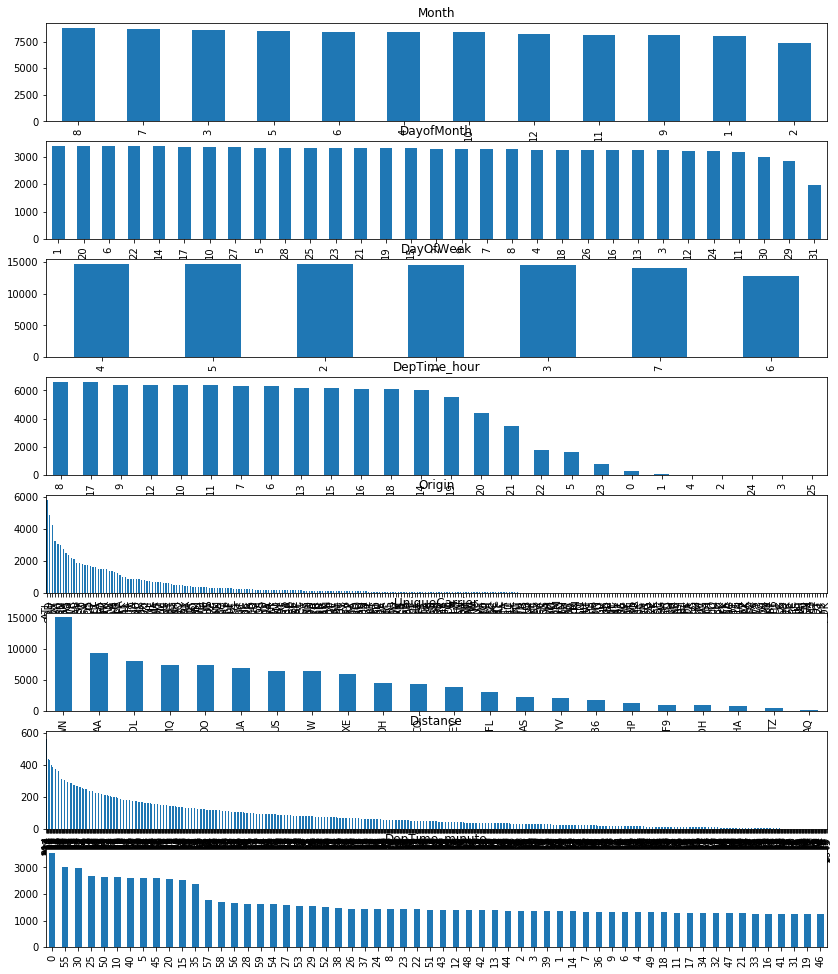

In [7]:
columns = ['Month', 'DayofMonth', 'DayOfWeek', 'DepTime_hour', 'Origin',
           'UniqueCarrier', 'Distance', 'DepTime_minute']

fig, ax = plt.subplots(len(columns), figsize=(14,17))
i = 0

for col in columns:
  train_df[col].value_counts().plot(kind='bar', ax=ax[i])
  ax[i].set_title(col)
  i += 1


In [0]:
def plot_corr(feat1_name, withTarget=False):
  fig, ax = plt.subplots(2, figsize=(13,7))
  if withTarget:
    target_sum =[]

  feat1_values = sorted(train_df[feat1_name].unique())
  flights_sum = []

  for feat in feat1_values:
    flights_sum.append(train_df[(train_df[feat1_name] == feat)].shape[0])
    if (withTarget):
      target_sum.append(train_df[(train_df[feat1_name] == feat) & \
                                 (train_df['dep_delayed_15min'] == 'Y')].shape[0])

  ax[0].plot(feat1_values, flights_sum)
  ax[0].set_xlabel(feat1_name)
  ax[0].set_ylabel('Flights')
  
  if (withTarget):
    ax[1].plot(feat1_values, target_sum)
    ax[1].set_xlabel(feat1_name)
    ax[1].set_ylabel('Flights delayed')


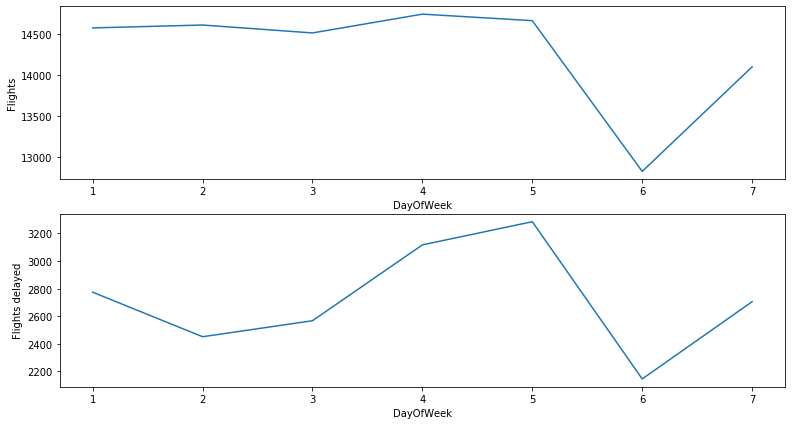

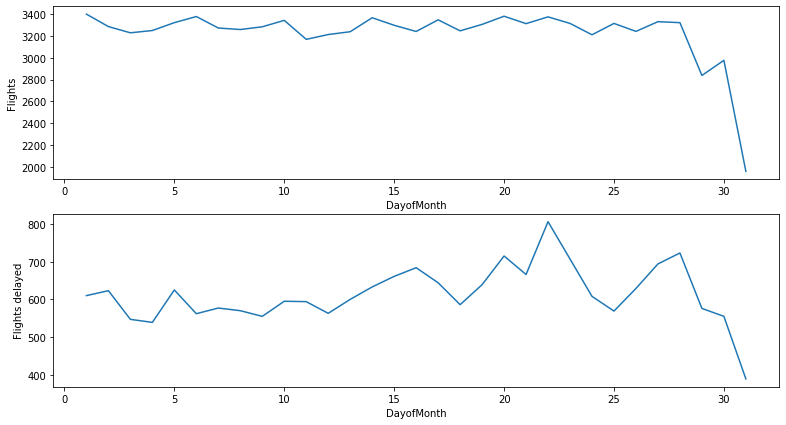

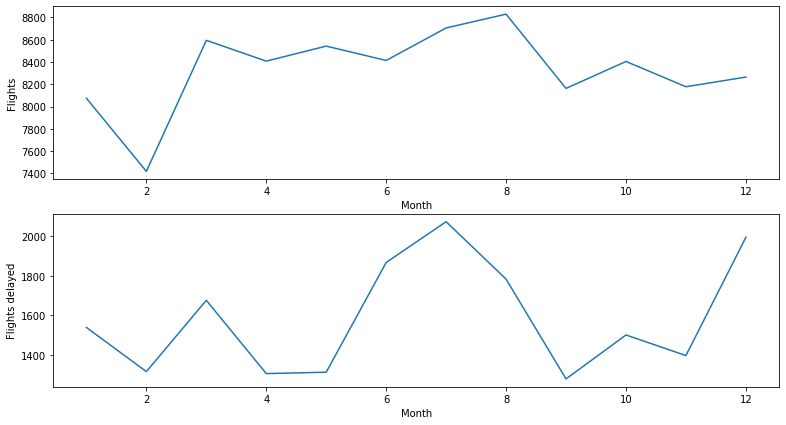

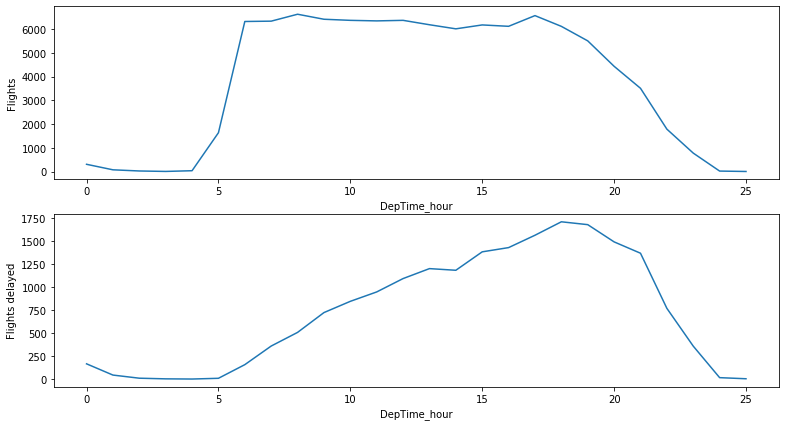

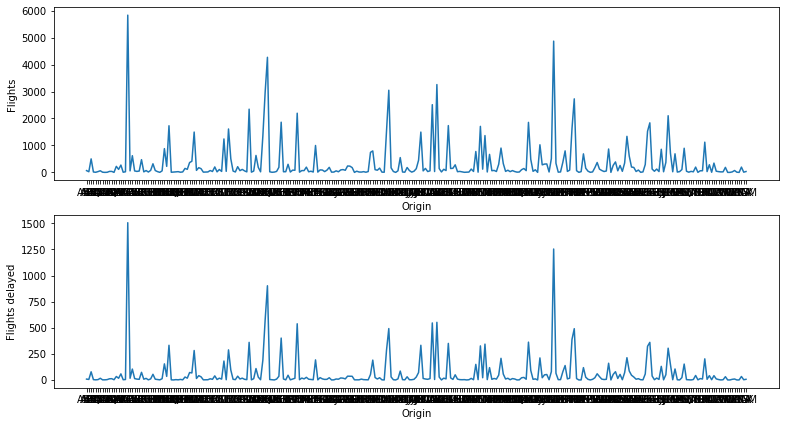

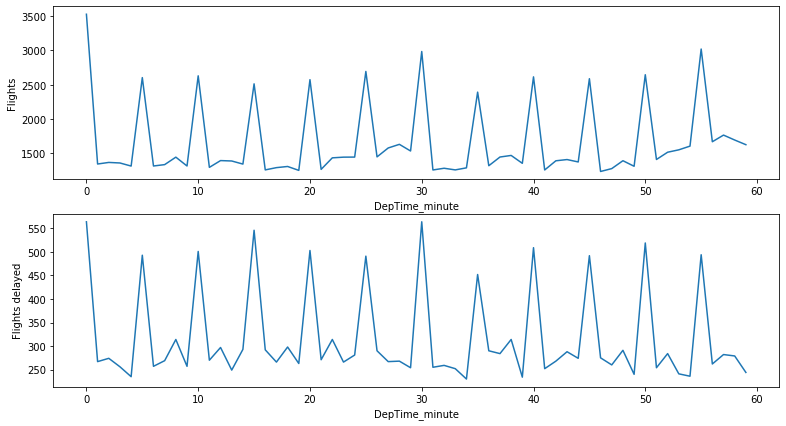

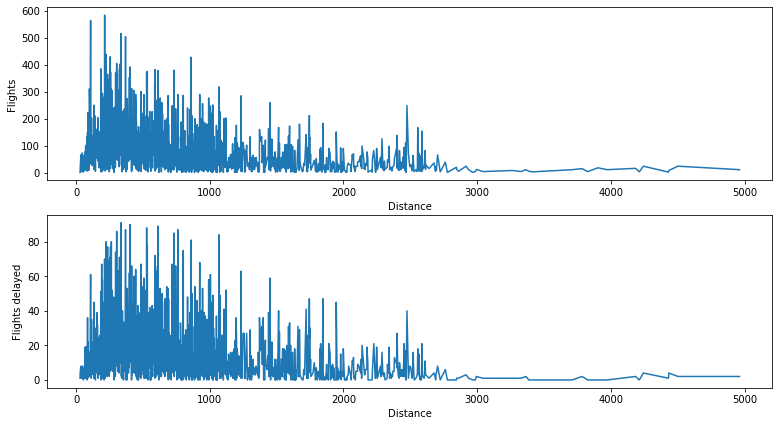

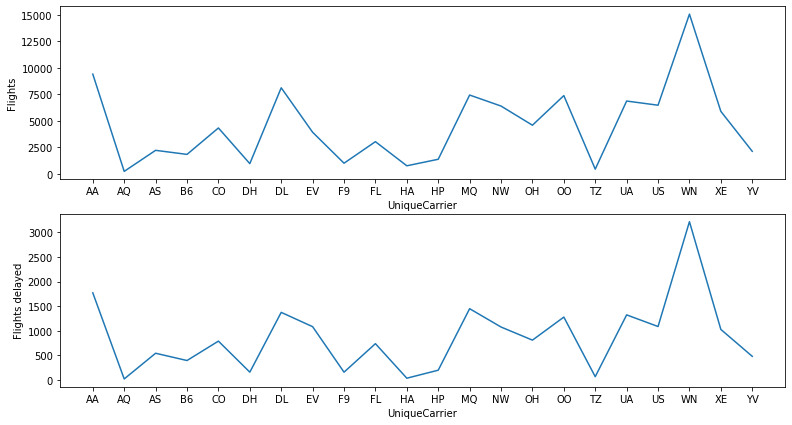

In [16]:
cols = ['DayOfWeek', 'DayofMonth', 'Month', 'DepTime_hour', 'Origin',
        'DepTime_minute', 'Distance', 'UniqueCarrier']

for feat in cols:
  plot_corr(feat, True)



**Generating new features:**

In [0]:
def calculate_load(df):
  low_load_airports  = []
  med_load_airports  = []
  high_load_airports = []  

  for airport in df['Origin'].unique():
    load = df[df['Origin'] == airport].shape[0]
    if load < 1000:
      low_load_airports.append(airport)
    elif (load >= 1000) & (load <= 2700):
      med_load_airports.append(airport)
    elif load > 2700:
      high_load_airports.append(airport)
    else:
      low_load_airports.append(airport)
      
  return low_load_airports, med_load_airports, high_load_airports

def get_airport_load(airportName):
  if airportName in low_load_airports:
    return 1
  elif airportName in med_load_airports:
    return 2
  elif airportName in high_load_airports:
    return 3
  else:
    return 1
  

In [0]:
low_dists = list(range(2600, 6000))
med_dists = list(range(1000, 2600))
high_dists = list(range(0, 1000))
low_dists.append(0)

def get_distance_cat(distance):
  if int(distance) in low_dists:
    return 1
  elif int(distance) in med_dists:
    return 2
  elif int(distance) in high_dists:
    return 3
  
def get_season(month):
  if month in [12, 1, 2]:
    return 1
  elif month in [3, 4, 5]:
    return 2
  elif month in [6, 7, 8]:
    return 3
  elif month in [9, 10, 11]:
    return 4
    

In [0]:
def gen_feats(df):
  df = df.copy()

  low_load_airports  = []
  med_load_airports  = []
  high_load_airports = []  
  
  low_load_airports, med_load_airports, high_load_airports = calculate_load(df)
  
  df['airport_load'] = df['Origin'].apply(get_airport_load).astype(np.int32)
  df['distance_cat'] = df['Distance'].apply(get_distance_cat).astype(np.int32)

  df['season']       = df['Month'].apply(get_season).astype(np.int32)
  df['daytime']      = (df['DepTime_hour'] // 6).astype(np.int32)
  df['flight']       = df['Origin'] + '-->' + df['Dest']
  df['Distance']     = np.log(df['Distance'])
  
  df['DepTime'] = df['DepTime'].astype(np.int32)
  
  df.loc[df['DepTime_hour'] == 24, 'DepTime_hour'] = 0
  df.loc[df['DepTime_hour'] == 25, 'DepTime_hour'] = 1
  
  
#   df['date'] = pd.concat([df['Month'], df['DayofMonth'], df['DayOfWeek']], axis=1).apply(get_date, axis=1)

  return df

In [0]:
train_df = gen_feats(train_df)

In [0]:
test_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/kaggle/ml_course/flight_delays/flight_delays_test.csv')

In [0]:
test_df = preprocess(test_df)
test_df = gen_feats(test_df)

**Encoding:**

In [0]:
train_split = train_df.shape[0]
full_df = pd.concat((train_df, test_df))
full_df['Distance'] = np.log(full_df['Distance'])

# Label Encoding
for col in ['Origin', 'Dest', 'UniqueCarrier', 'daytime', 'flight']:
    full_df[col] = pd.factorize(full_df[col])[0]

# Categorical columns
cat_cols = ['Month', 'DayofMonth', 'DayOfWeek', 'UniqueCarrier', 'flight',
            'Origin', 'Dest', 'DepTime_hour', 'daytime', 'season', 'airport_load', 
            'distance_cat']

# Converting categorical columns to type 'category' as required by LGBM
for c in cat_cols:
      full_df[c] = full_df[c].astype('category')
    
# Split into train and test
train_df, test_df = full_df.iloc[:train_split], full_df.iloc[train_split:]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [0]:
train_df.head()

,DayOfWeek,DayofMonth,DepTime,DepTime_hour,DepTime_minute,Dest,Distance,Month,Origin,UniqueCarrier,airport_load,daytime,dep_delayed_15min,distance_cat,flight,season
0,7,21,1934,19,34,0,0.634686,8,0,0,3,0,N,3,0,3
1,3,20,1548,15,48,1,0.645015,4,1,1,1,1,N,3,1,2
2,5,2,1422,14,22,2,0.586041,9,2,2,1,1,N,3,2,4
3,6,25,1015,10,15,3,0.648473,11,3,3,3,2,N,3,3,4
4,6,7,1828,18,28,4,0.587578,10,4,4,2,0,Y,3,4,4


In [0]:
test_df.drop('dep_delayed_15min', axis=1, inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [0]:
categ_feat_idx = np.where(train_df.drop(['dep_delayed_15min'], axis=1).dtypes == 'category')[0]
categ_feat_idx

array([ 0,  1,  3,  5,  7,  8,  9, 10, 11, 12, 13, 14])

In [0]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 16 columns):
DayOfWeek            100000 non-null category
DayofMonth           100000 non-null category
DepTime              100000 non-null int32
DepTime_hour         100000 non-null category
DepTime_minute       100000 non-null int32
Dest                 100000 non-null category
Distance             100000 non-null float64
Month                100000 non-null category
Origin               100000 non-null category
UniqueCarrier        100000 non-null category
airport_load         100000 non-null category
daytime              100000 non-null category
dep_delayed_15min    100000 non-null object
distance_cat         100000 non-null category
flight               100000 non-null category
season               100000 non-null category
dtypes: category(12), float64(1), int32(2), object(1)
memory usage: 4.7+ MB


**Allocate a hold-out set (a.k.a. a validation set) to validate the model**

In [0]:
X_train = train_df.drop(['dep_delayed_15min'], axis=1).values
y_train = train_df['dep_delayed_15min'].map({'Y': 1, 'N': 0}).values
X_test = test_df.values

In [0]:
X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train, y_train, 
                                                                test_size=0.3, 
                                                                random_state=17)

In [0]:
ctb = CatBoostClassifier(random_seed=17, silent=True, task_type='GPU')

**Train Catboost with default arguments, passing only the indexes of categorical features.**

In [0]:
%%time
ctb = CatBoostClassifier(random_seed=17, silent=True, task_type='GPU', learning_rate=0.1)
ctb.fit(X_train_part, y_train_part, cat_features=categ_feat_idx);

CPU times: user 47.1 s, sys: 17.4 s, total: 1min 4s
Wall time: 49.2 s


In [0]:
for feat, imp in zip(train_df.drop('dep_delayed_15min', axis=1).columns[categ_feat_idx], ctb.get_feature_importance()):
  print(feat, ':', imp)

DayOfWeek : 4.91252414635785
DayofMonth : 6.055331011533553
DepTime_hour : 6.791857991962989
Dest : 15.792582974381935
Month : 13.631715238113767
Origin : 7.061695533004271
UniqueCarrier : 4.1640404847007435
airport_load : 4.799222957497162
daytime : 7.268617825583331
distance_cat : 9.82409929381562
flight : 0.0
season : 4.268093925018129


In [0]:
for feat, imp in zip(train_df.drop('dep_delayed_15min', axis=1).columns[categ_feat_idx], ctb.get_feature_importance()):
  print(feat, ':', imp)

DayOfWeek : 4.91252414635785
DayofMonth : 6.055331011533553
DepTime_hour : 6.791857991962989
Dest : 15.792582974381935
Month : 13.631715238113767
Origin : 7.061695533004271
UniqueCarrier : 4.1640404847007435
airport_load : 4.799222957497162
daytime : 7.268617825583331
distance_cat : 9.82409929381562
flight : 0.0
season : 4.268093925018129


In [0]:
ctb_valid_pred = ctb.predict_proba(X_valid)[:, 1]

In [0]:
ctb_valid_pred = ctb.predict_proba(X_valid)

In [0]:
roc_auc_score(y_valid, ctb_valid_pred[:, 1])

0.8068161117499538

**Train on the whole train set, make prediction on the test set**

In [0]:
%%time
ctb.fit(X_train, y_train, cat_features=categ_feat_idx);

CPU times: user 51.2 s, sys: 19.9 s, total: 1min 11s
Wall time: 54.3 s


In [0]:
ctb_test_pred = ctb.predict_proba(X_test)[:, 1]

In [0]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    sample_sub = pd.read_csv('/content/drive/My Drive/Colab Notebooks/kaggle/ml_course/flight_delays/sample_submission.csv', 
                             index_col='id')
    sample_sub['dep_delayed_15min'] = ctb_test_pred
    sample_sub.to_csv('ctb_pred.csv')